In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
proj_notebooks_root = pathlib.Path().absolute()
proj_root_path = proj_notebooks_root.parent
data_path = proj_root_path / "data"

if proj_root_path not in sys.path:
    sys.path.insert(0, proj_root_path.as_posix())
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_notebooks_root}")
print(f"Project Data Path: {data_path}")

Updated Python Path
Project Root Path: /home/default/workspace/roadsegm
Project Source Root Path: /home/default/workspace/roadsegm/ActiveLearning
Project Data Path: /home/default/workspace/roadsegm/data


In [2]:
# !pip install --user kaggle

In [3]:
# !mkdir /home/default/.kaggle/
# !touch /home/default/.kaggle/kaggle.json

# api_token = {"username":"username","key":"key"}

# import json

# with open('/home/default/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json


# !sudo apt-get update
# !sudo apt-get install unzip


In [4]:
!kaggle datasets download --help

usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will delete the zip file when completed.
  -o, --force           Skip check whether local version of file is up to date, force file download
  -q, --quiet           Suppress printing information about the upload/download progress


In [5]:
base_dir = data_path / 'crack_segmentation_dataset'
if not base_dir.exists():
    ! kaggle datasets download -p {data_path.as_posix()} -d lakshaymiddha/crack-segmentation-dataset
    ! unzip -q {data_path / 'crack-segmentation-dataset.zip'} -d {data_path}
    ! rm {data_path / 'crack-segmentation-dataset.zip'} 
else:
    print("Found dataset at ", base_dir.as_posix())


Found dataset at  /home/default/workspace/roadsegm/data/crack_segmentation_dataset


In [6]:
f = [y for y in (base_dir).glob('*')] 
print(f"Found {len(f)} dirs in {base_dir}")

counts = {}

for i in f:
    files = [y for y in i.glob('*')] 
    num = len(files)
    counts[i.stem] = num
print(counts)
files

Found 5 dirs in /home/default/workspace/roadsegm/data/crack_segmentation_dataset
{'test': 2, 'readme': 0, 'train': 2, 'masks': 11298, 'images': 11298}


[PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/cracktree200_6240.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Volker_DSC01680_133_920_1599_1773.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A2885_240_400_3555_4056.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A3115_1837_674_2470_3120.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/CRACK500_20160318_181627_1921_721.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/noncrack_noncrack_concrete_wall_15_0.jpg.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A2869_444_1582_3292_3830.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/

In [7]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import torchvision
from tqdm import tqdm
from torchinfo import summary
import time

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [8]:
X_dir = base_dir/'train'/'images'
y_dir = base_dir/'train'/'masks'

X_files = [y for y in X_dir.glob('*')] 

for i in X_files:
    assert((y_dir / i.name).exists())

all_files = [(x, (y_dir / x.name)) for x in X_dir.glob('*')] 
for i in range(10):
    print(all_files[i][0].name)


cracktree200_6240.jpg
Volker_DSC01680_133_920_1599_1773.jpg
Rissbilder_for_Florian_9S6A2885_240_400_3555_4056.jpg
CRACK500_20160318_181627_1921_721.jpg
noncrack_noncrack_concrete_wall_15_0.jpg.jpg
Rissbilder_for_Florian_9S6A2869_444_1582_3292_3830.jpg
Rissbilder_for_Florian_9S6A3105_3_424_3449_4056.jpg
Rissbilder_for_Florian_9S6A2812_62_375_3665_3538.jpg
Rissbilder_for_Florian_9S6A2852_1479_510_3289_2569.jpg
GAPS384_train_0560_541_1.jpg


In [9]:
class CracksDataset(torch.utils.data.Dataset):
    def __init__(self, files,image_transforms=None, both_transforms=None):
        self.files = files
        
        self.image_transforms = image_transforms
        self.both_transforms = both_transforms
        self.segment_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.files)
    

    def __getitem__(self, idx):
        imagePath, segmentPath = self.files[idx]
        image = Image.open(imagePath)
        segment = self.segment_transforms(Image.open(segmentPath))
        segment = segment.long()
#         print(segment)
        
            
        if self.image_transforms is not None:
            image = self.image_transforms(image)
            
        if self.both_transforms is not None:
            image = self.both_transforms(image)
            segment = self.both_transforms(segment)
        
        return image, segment


In [10]:
data_transforms = {
    'both': transforms.Compose([
#         transforms.CenterCrop((630, 1024))
    ]),
    'images': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

all_files = all_files
random.shuffle(all_files)

train_count = len(all_files)*8//10

train_dataset = CracksDataset(all_files[:train_count],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

val_dataset = CracksDataset(all_files[train_count:],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

print(f"Created train_dataset with {len(train_dataset)} datapoints.")
print(f"Created val_dataset with {len(val_dataset)} datapoints.")


batch_size = 36
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=8)

Created train_dataset with 7682 datapoints.
Created val_dataset with 1921 datapoints.


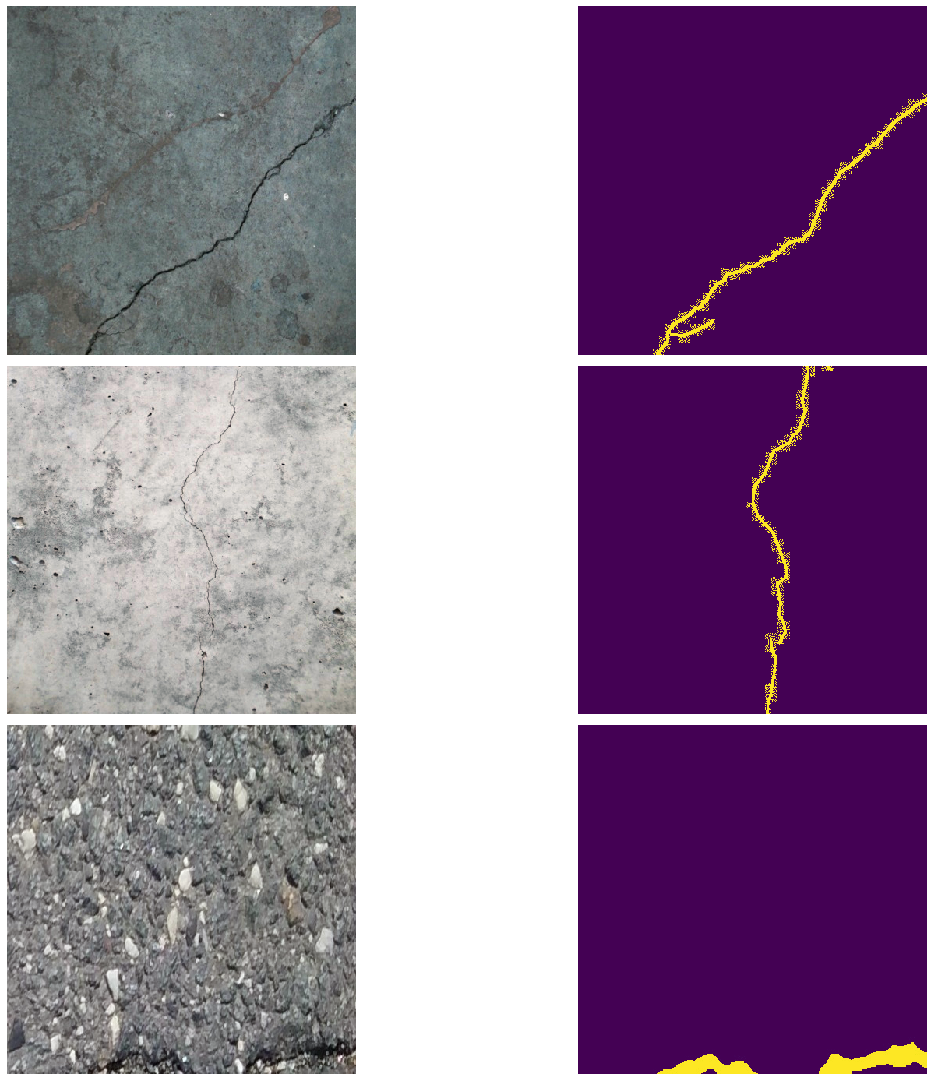

In [11]:
batch = next(iter(train_dataloader))
tensors = batch[0]
segments = batch[1]

# tensors, metadata
y = int(len(tensors)/2+0.5); x = 2
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(min(len(tensors)//2, 3)):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*2) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*2) + 2)
    image = segments[i].permute(1,2,0).cpu().numpy()
    image = np.squeeze(image)
#     image = np.atleast_3d(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


In [12]:
def get_eval_metrics(pred, gold, threshold = 0.5):
    pred = (pred > threshold).long()
    hits = torch.sum(torch.mul(pred, gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets

def train_loop(dataloader, model, loss_fn, optimizer, history, lr_sched = None):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    bar_format = "{l_bar}{bar} {elapsed}<{remaining} {rate_fmt}{postfix}"
    
    with tqdm(dataloader, unit="batch", bar_format=bar_format) as tepoch:
        for X, y in tepoch:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(X)
                loss = loss_fn(output, y)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            
            loss_sum += loss.item()

            if(lr_sched is not None):
                lr_sched.step()

            loss = loss.item()
            tepoch.set_postfix(
                loss=round(loss, 4), 
                lr=round(lr_sched.get_last_lr()[0], 4)
            )
        history['train_lr'].append(lr_sched.get_last_lr()[0])
        history['train_loss'].append(loss_sum/len(dataloader))
    
    
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    total_hits = 0
    total_shots = 0
    total_targets = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", unit="batches"):
            X = X.to(device)
            y = y.to(device)
#             print(y.shape)
            
            output = model(X)
            
            loss += loss_fn(output, y).item()
            hits, shots, targets = get_eval_metrics(output, y)
            total_hits += hits
            total_shots += shots
            total_targets += targets

    loss /= num_batches
    history['test_loss'].append(loss)
    history['test_hits'].append(total_hits)
    history['test_shots'].append(total_shots)
    history['test_targets'].append(total_targets)
    
    if total_shots == 0:
        precision = 0
        recall = 0
        f1score = 0
    else:
        precision = total_hits/total_shots
        recall = total_hits/total_targets
        f1score = (2 * precision * recall)/(precision + recall)
        

    history['test_precision'].append(precision)
    history['test_recall'].append(recall)
    history['test_f1score'].append(f1score)
    

In [14]:
class SegModel(torch.nn.Module):

    def __init__(self, numclasses):
        super(SegModel, self).__init__()

        self.fcn = torchvision.models.segmentation.fcn_resnet50(
            weights=None, 
            num_classes = numclasses, 
            aux_loss = False,
            weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT)
#         self.softmax = torch.nn.Softmax(0)

    def forward(self, x):
        x = self.fcn(x)['out']
#         x = self.softmax(x)
        return x

In [15]:
model = SegModel(1)
model.to(device)

epochs = 10

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9)

lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr=0.01, 
                       steps_per_epoch=len(train_dataloader), 
                       epochs=epochs)

loss_fn = torch.nn.BCEWithLogitsLoss()


In [ ]:
# Creates a GradScaler once at the beginning of training.

scaler = GradScaler()

history = {
    'train_lr':[],
    'train_loss':[],
    'test_loss':[],
    'test_hits':[],
    'test_shots':[],
    'test_targets':[],
    'test_precision': [],
    'test_recall': [],
    'test_f1score': []
}

begin = time.time()
  
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch+1}')
    print("-------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, history, lr_sched)
    test_loop(val_dataloader, model, loss_fn, history)
    print(f"Training Loss: {history['train_loss'][-1]:.5}\tTesting Loss: {history['test_loss'][-1]:.5}")

end = time.time()


# watch -d -n 0.5 nvidia-smi
# Taking ~ 3 mins per epoch to train


Epoch 1
-------------


100%|██████████ 03:09<00:00  1.13batch/s, loss=0.0968, lr=0.001 
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:21,  1.54s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:02<00:49,  1.05batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:38,  1.31batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:03<00:33,  1.48batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:30,  1.61batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:28,  1.69batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.75batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:25,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:25,  1.74batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:24,  1.78batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:23,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:08<00:22,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:09<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:11<00:18,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:15<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:22<00:08,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.29batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.81batches/s]


Training Loss: 0.16791	Testing Loss: 0.10707

Epoch 2
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0941, lr=0.0028
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:07,  1.28s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:43,  1.18batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:35,  1.42batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.57batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.67batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:21,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:11<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:26<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.83batches/s]


Training Loss: 0.093778	Testing Loss: 0.083074

Epoch 3
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0706, lr=0.0052
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:12,  1.36s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:45,  1.14batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.39batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.54batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.65batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:28,  1.71batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.76batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:16,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:15,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.27batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.83batches/s]


Training Loss: 0.077449	Testing Loss: 0.073325

Epoch 4
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0727, lr=0.0076
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:12,  1.37s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:45,  1.14batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.40batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.67batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.74batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:22,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:21,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:11<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:09,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:19<00:09,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:08,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:20<00:08,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:07,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.90batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:26<00:02,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:27<00:01,  1.92batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.91batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.32batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.85batches/s]


Training Loss: 0.069541	Testing Loss: 0.067501

Epoch 5
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0539, lr=0.0094
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:08,  1.28s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:43,  1.19batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:35,  1.42batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.66batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.72batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.83batches/s]


Training Loss: 0.064204	Testing Loss: 0.062107

Epoch 6
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0662, lr=0.01  
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:09,  1.32s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.17batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.66batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.25batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.060891	Testing Loss: 0.059445

Epoch 7
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0626, lr=0.0099
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:10,  1.32s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.17batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.65batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:28,  1.71batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.76batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.25batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.83batches/s]


Training Loss: 0.058523	Testing Loss: 0.057737

Epoch 8
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0547, lr=0.0095
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:09,  1.31s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.17batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.65batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.72batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.78batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.056387	Testing Loss: 0.0563

Epoch 9
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0499, lr=0.0089
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:08,  1.29s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.18batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:35,  1.42batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.57batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.67batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.72batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:07,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.89batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.055041	Testing Loss: 0.05533

Epoch 10
-------------


100%|██████████ 03:07<00:00  1.14batch/s, loss=0.0535, lr=0.0081
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:07,  1.28s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:43,  1.19batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:35,  1.42batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.57batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.66batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.76batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.25batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.053995	Testing Loss: 0.054356

Epoch 11
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0689, lr=0.0072
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:07,  1.27s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:43,  1.19batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.42batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.57batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.66batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:14,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:13,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.053109	Testing Loss: 0.053664

Epoch 12
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0579, lr=0.0061
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:09,  1.31s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.17batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.54batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.64batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:28,  1.70batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.75batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.052179	Testing Loss: 0.053053

Epoch 13
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0475, lr=0.005 
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:08,  1.29s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.18batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.67batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.78batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.88batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.27batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.051469	Testing Loss: 0.052512

Epoch 14
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0801, lr=0.0039
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:14,  1.40s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:46,  1.12batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:37,  1.38batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:03<00:32,  1.54batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.64batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:28,  1.71batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.76batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.79batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:21,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:14,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.81batches/s]


Training Loss: 0.051051	Testing Loss: 0.052052

Epoch 15
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0558, lr=0.0028
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:09,  1.31s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.17batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.41batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.56batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.66batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.25batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.050413	Testing Loss: 0.05217

Epoch 16
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0372, lr=0.0019
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:10,  1.33s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:44,  1.16batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.40batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.55batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.65batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:27,  1.72batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.0499	Testing Loss: 0.05157

Epoch 17
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0799, lr=0.0011
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:09,  1.32s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:45,  1.16batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:36,  1.40batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:32,  1.55batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.65batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:04<00:27,  1.72batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.77batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:05<00:25,  1.80batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:24,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:19<00:10,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.24batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.049662	Testing Loss: 0.05158

Epoch 18
-------------


100%|██████████ 03:08<00:00  1.14batch/s, loss=0.0631, lr=0.0005
Testing:   0%|          | 0/54 [00:00<?, ?batches/s]

torch.Size([36, 1, 448, 448])


Testing:   2%|▏         | 1/54 [00:01<01:05,  1.24s/batches]

torch.Size([36, 1, 448, 448])


Testing:   4%|▎         | 2/54 [00:01<00:43,  1.21batches/s]

torch.Size([36, 1, 448, 448])


Testing:   6%|▌         | 3/54 [00:02<00:35,  1.44batches/s]

torch.Size([36, 1, 448, 448])


Testing:   7%|▋         | 4/54 [00:02<00:31,  1.58batches/s]

torch.Size([36, 1, 448, 448])


Testing:   9%|▉         | 5/54 [00:03<00:29,  1.67batches/s]

torch.Size([36, 1, 448, 448])


Testing:  11%|█         | 6/54 [00:03<00:27,  1.73batches/s]

torch.Size([36, 1, 448, 448])


Testing:  13%|█▎        | 7/54 [00:04<00:26,  1.78batches/s]

torch.Size([36, 1, 448, 448])


Testing:  15%|█▍        | 8/54 [00:04<00:25,  1.81batches/s]

torch.Size([36, 1, 448, 448])


Testing:  17%|█▋        | 9/54 [00:05<00:24,  1.82batches/s]

torch.Size([36, 1, 448, 448])


Testing:  19%|█▊        | 10/54 [00:06<00:23,  1.83batches/s]

torch.Size([36, 1, 448, 448])


Testing:  20%|██        | 11/54 [00:06<00:23,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  22%|██▏       | 12/54 [00:07<00:22,  1.84batches/s]

torch.Size([36, 1, 448, 448])


Testing:  24%|██▍       | 13/54 [00:07<00:22,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  26%|██▌       | 14/54 [00:08<00:21,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  28%|██▊       | 15/54 [00:08<00:20,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  30%|██▉       | 16/54 [00:09<00:20,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  31%|███▏      | 17/54 [00:09<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  33%|███▎      | 18/54 [00:10<00:19,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  35%|███▌      | 19/54 [00:10<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  37%|███▋      | 20/54 [00:11<00:18,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  39%|███▉      | 21/54 [00:11<00:17,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  41%|████      | 22/54 [00:12<00:17,  1.85batches/s]

torch.Size([36, 1, 448, 448])


Testing:  43%|████▎     | 23/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  44%|████▍     | 24/54 [00:13<00:16,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  46%|████▋     | 25/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  48%|████▊     | 26/54 [00:14<00:15,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  50%|█████     | 27/54 [00:15<00:14,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  52%|█████▏    | 28/54 [00:15<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  54%|█████▎    | 29/54 [00:16<00:13,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  56%|█████▌    | 30/54 [00:16<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  57%|█████▋    | 31/54 [00:17<00:12,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  59%|█████▉    | 32/54 [00:17<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  61%|██████    | 33/54 [00:18<00:11,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  63%|██████▎   | 34/54 [00:18<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  65%|██████▍   | 35/54 [00:19<00:10,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  67%|██████▋   | 36/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  69%|██████▊   | 37/54 [00:20<00:09,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  70%|███████   | 38/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  72%|███████▏  | 39/54 [00:21<00:08,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  74%|███████▍  | 40/54 [00:22<00:07,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  76%|███████▌  | 41/54 [00:22<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  78%|███████▊  | 42/54 [00:23<00:06,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  80%|███████▉  | 43/54 [00:23<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  81%|████████▏ | 44/54 [00:24<00:05,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  83%|████████▎ | 45/54 [00:24<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  85%|████████▌ | 46/54 [00:25<00:04,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  87%|████████▋ | 47/54 [00:25<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  89%|████████▉ | 48/54 [00:26<00:03,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  91%|█████████ | 49/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  93%|█████████▎| 50/54 [00:27<00:02,  1.86batches/s]

torch.Size([36, 1, 448, 448])


Testing:  94%|█████████▍| 51/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing:  96%|█████████▋| 52/54 [00:28<00:01,  1.87batches/s]

torch.Size([36, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  2.26batches/s]

torch.Size([13, 1, 448, 448])


Testing: 100%|██████████| 54/54 [00:29<00:00,  1.82batches/s]


Training Loss: 0.049464	Testing Loss: 0.051312

Epoch 19
-------------


 24%|██▍        00:45<02:23  1.14batch/s, loss=0.0391, lr=0.0004

In [ ]:
models_dir = proj_root_path / 'models'
if not models_dir.exists():
    models_dir.mkdir()

# inf_model_name = "30-FCN-inference.pth"
ent_model_name = "01-FCN-simple.pth"
# torch.save(model.state_dict(), models_dir / inf_model_name)
torch.save(model, models_dir / ent_model_name)

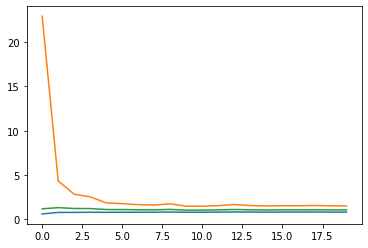

In [21]:
epochs_range = range(epochs)

plt.plot(epochs_range, history['test_precision'], label='Precision')
plt.plot(epochs_range, history['test_recall'], label='Recall')
plt.plot(epochs_range, history['test_f1score'], label='F1 Score')

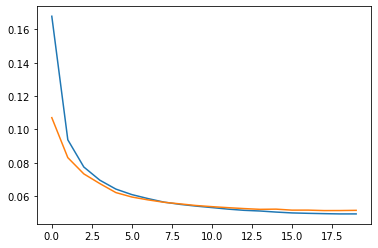

In [22]:

# plt.figure(figsize=(8,8))
# plt.subplots(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['test_loss'], label='Training Loss')

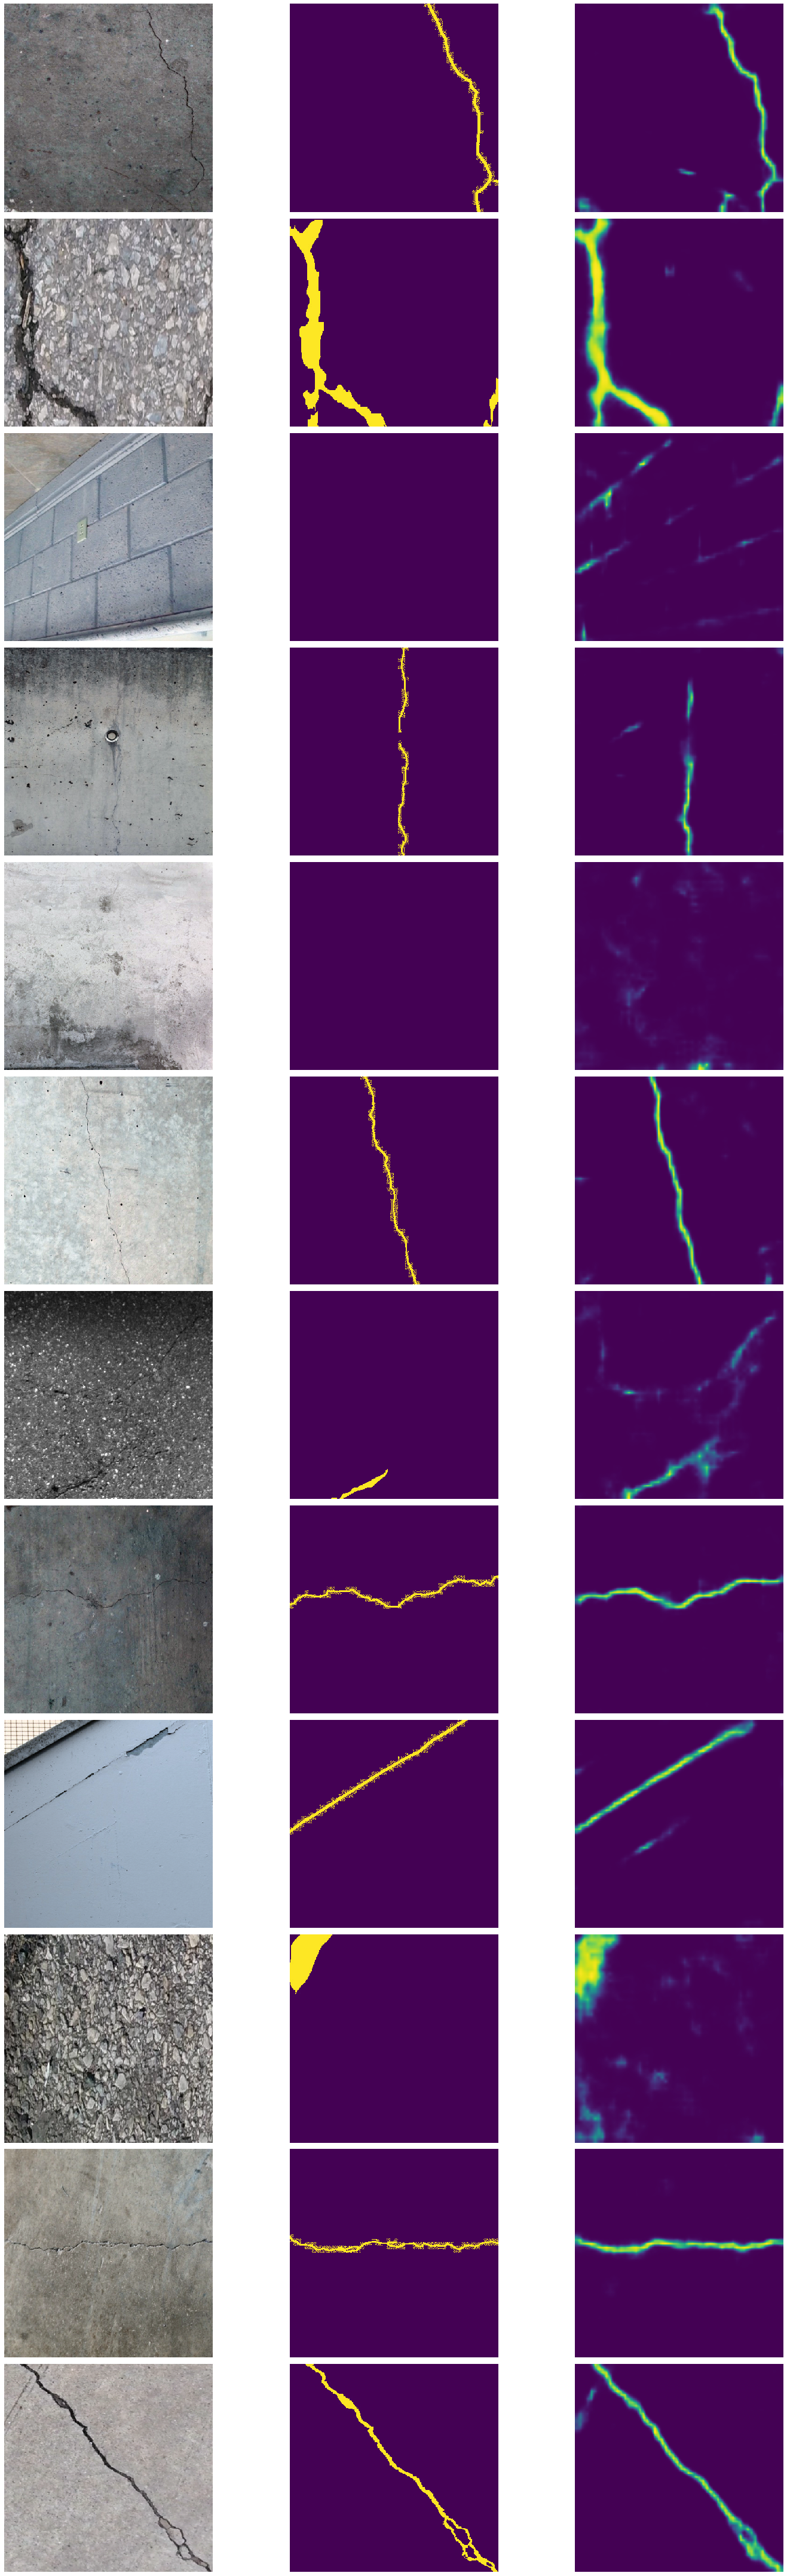

In [32]:
batch = next(iter(val_dataloader))
tensors = batch[0].to(device)
segments = batch[1]

with torch.no_grad():
    output = torch.sigmoid(model(tensors))

y = max(len(tensors)//3, 1)
x = 3
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*3) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 2)
    image = segments[i].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 3)
    image = output[i].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


(array([183944.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  16760.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

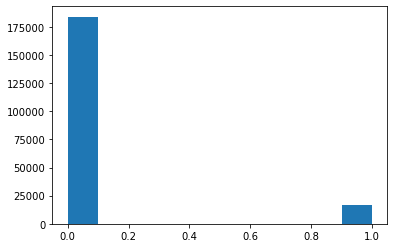

In [34]:
plt.hist((output[1].cpu().numpy().flatten() > 0.5).astype(int))

(array([183744.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  16960.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

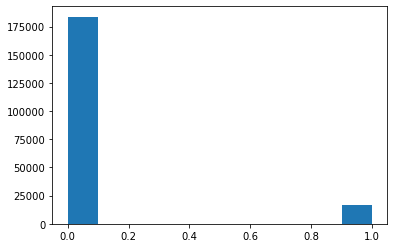

In [62]:
plt.hist(segments[1].cpu().numpy().flatten())

In [64]:
np.sum((output[1] > 0.5).cpu().numpy().astype(int) * segments[1].cpu().numpy().astype(int))

13022

In [1]:
def get_eval_metrics(pred, gold, threshold = 0.5):
    pred = (pred > threshold).long()
    hits = torch.sum(torch.mul(pred, gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets

hits, shots, targets = get_eval_metrics(output[1].cpu(), segments[1])
precision = hits/shots
recall = hits/targets
f1score = (2 * precision * recall)/(precision + recall)

print("Hits:", hits)
print("Shots:", shots)
print("Targets:", targets)

print("Precision:",precision)
print("Recall:", recall)
print("F1 score:", f1score)

NameError: name 'output' is not defined